In [48]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch
import functions.handy_functions as hf

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [49]:
#Set directory of found pairs
main_dir='/cloud/skogsstyrelsen_pairs/'
directories=os.listdir(main_dir)

In [50]:
#Import and format data
ims_all=[]
temporals_all=[]
for dir in directories:
    data_clear=xr.load_dataset(main_dir+dir+'/clear_data.nc', engine='netcdf4', decode_times=True)
    data_cloudy=xr.load_dataset(main_dir+dir+'/cloudy_data.nc', engine='netcdf4', decode_times=True)

    variables=data_clear.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data

    ## Save image ##
    im_clear=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
    im_clear[:,:,0]=b02
    im_clear[:,:,1]=b03
    im_clear[:,:,2]=b04
    im_clear[:,:,3]=b05
    im_clear[:,:,4]=b06
    im_clear[:,:,5]=b07
    im_clear[:,:,6]=b08
    im_clear[:,:,7]=b8a
    im_clear[:,:,8]=b09
    im_clear[:,:,9]=b10
    im_clear[:,:,10]=b11
    im_clear[:,:,11]=b12
    im_clear[:,:,12]=sun_z

    variables=data_cloudy.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data

    ## Save image ##
    im_cloudy=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
    im_cloudy[:,:,0]=b02
    im_cloudy[:,:,1]=b03
    im_cloudy[:,:,2]=b04
    im_cloudy[:,:,3]=b05
    im_cloudy[:,:,4]=b06
    im_cloudy[:,:,5]=b07
    im_cloudy[:,:,6]=b08
    im_cloudy[:,:,7]=b8a
    im_cloudy[:,:,8]=b09
    im_cloudy[:,:,9]=b10
    im_cloudy[:,:,10]=b11
    im_cloudy[:,:,11]=b12
    im_cloudy[:,:,12]=sun_z

    im_pair=[im_clear,im_cloudy]
    ims_all.append(im_pair)
    temporals_all.append([data_clear.coords['t'].data[0],data_cloudy.coords['t'].data[0]])

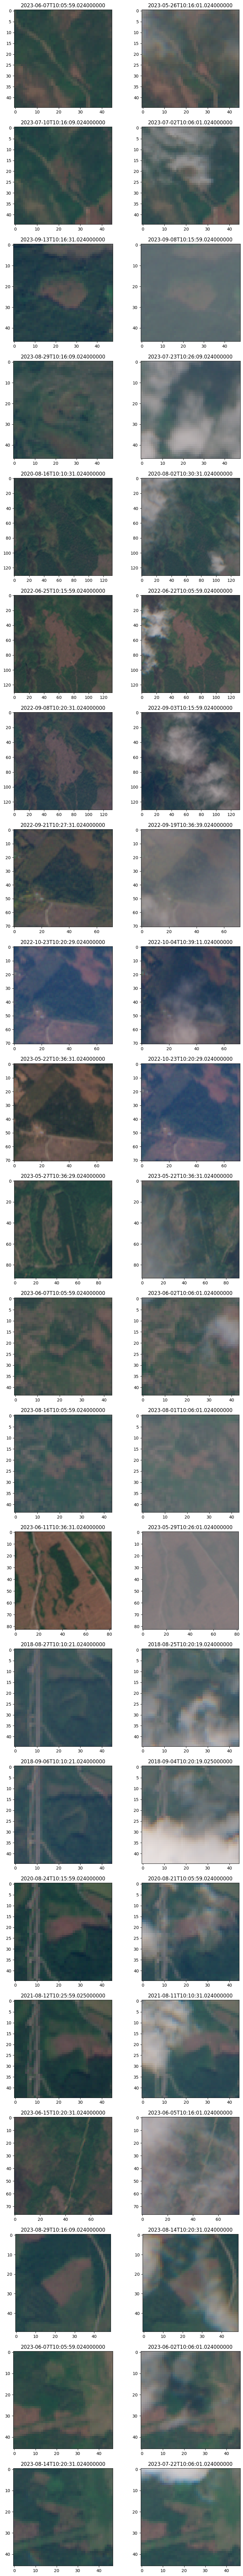

In [51]:
#Plot all clear/cloudy pairs
ncols=2
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    pair_c+=1

Now import model without COT estimation and predict

In [52]:
main_filepath='pytorch_models/COT_est_inp_noCOT'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
    
quantiles = np.array([0.1,0.5,0.9])
est = np.where(quantiles==0.5)[0].item()

In [53]:
#Make predictions and save with uncertanties

preds_all=[]
uncertainties_all=[]
for i,pair in enumerate(ims_all):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r)
        else:   
            pred=pred+model.predict(im_cloud_r)
    pred=pred/len(models)

    ##Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,est],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)

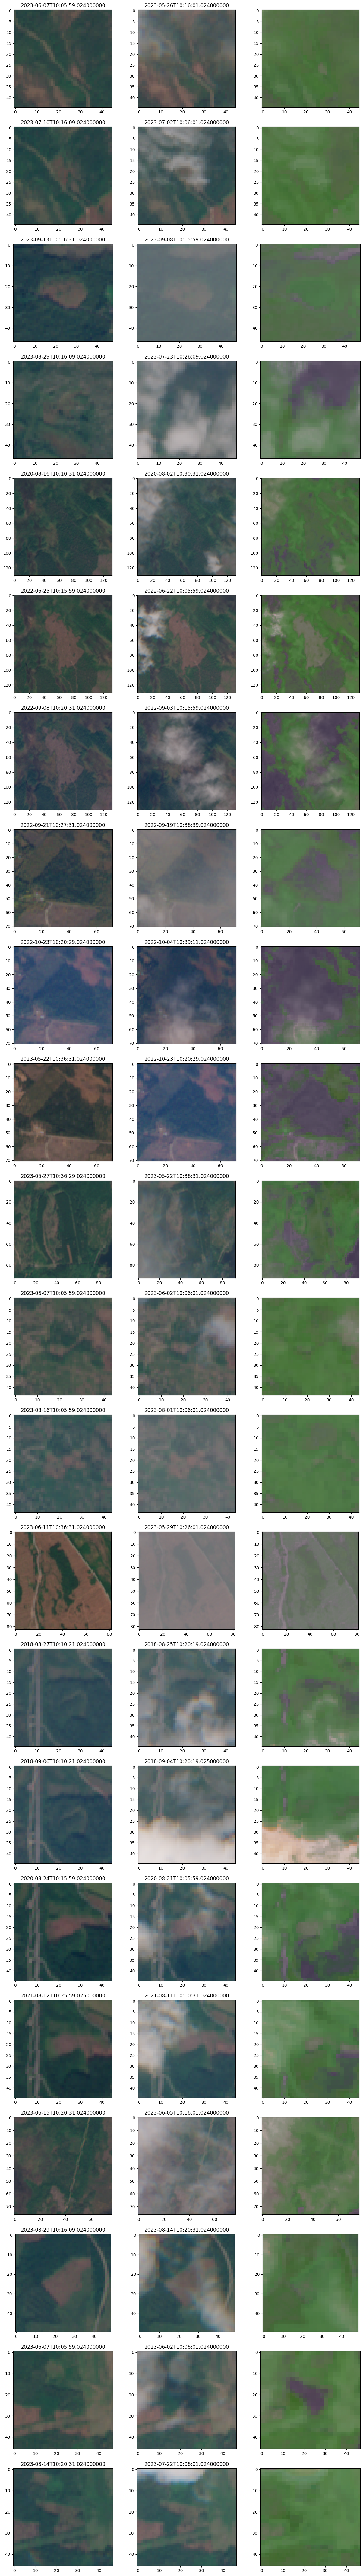

In [54]:
#Print clear, cloudy and predictions
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(preds_all[i]))
    pair_c+=1

In [55]:
#Evaluate through NMSE

n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm(np.square((im_clear[:,:,0:12])-(im_cloud[:,:,0:12])),axis=(0,1))**2
    norm_pred=np.linalg.norm(np.square((im_clear[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
    norm_gt=np.linalg.norm(np.square(im_clear[:,:,0:12]),axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))


NMSE before correction, Band 2: 2.305161168976403
NMSE after correction, Band 2: 0.1062773996431496
 
NMSE before correction, Band 3: 6.4023670272455515
NMSE after correction, Band 3: 0.8011529727914241
 
NMSE before correction, Band 4: 34.756426329439165
NMSE after correction, Band 4: 10.85832731940854
 
NMSE before correction, Band 5: 9.274040971995303
NMSE after correction, Band 5: 3.4661099964778654
 
NMSE before correction, Band 6: 0.49266081014717505
NMSE after correction, Band 6: 0.2221505170452735
 
NMSE before correction, Band 7: 0.26749905046269823
NMSE after correction, Band 7: 0.14432487544605455
 
NMSE before correction, Band 8: 0.21176322362223646
NMSE after correction, Band 8: 0.14930744942000257
 
NMSE before correction, Band 8A: 0.19049108048186822
NMSE after correction, Band 8A: 0.1113109609502157
 
NMSE before correction, Band 9: 4.577976280854691
NMSE after correction, Band 9: 1.660833478254927
 
NMSE before correction, Band 10: 33.61172229187585
NMSE after correcti

Now perform COT estimation

In [56]:
#For trials with COT est:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load all COT est models
model_load_paths=['smhi_models3/0/model_it_2000000','smhi_models3/1/model_it_2000000', 'smhi_models3/2/model_it_2000000','smhi_models3/3/model_it_2000000', 'smhi_models3/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

#Set training data means and std's for normalization
means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]


In [57]:
#Make COT_predictions and append to cloudy image data, both estimation and thresholded dummies
ims_all_wCOT=[]
ims_all_wCOT_dum=[]
for i,pair in enumerate(ims_all):
    im_clear=pair[0]
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    #Normalize
    inputs = (im_cloud_r - means) / stds

    image_input_tens=torch.Tensor(inputs).to(device)

    #Make predictions
    preds = 0
    for model_cot in models_cot:
        curr_preds=model_cot(image_input_tens)/len(models_cot)
        preds=preds+curr_preds

    image_pred_cot=50*preds.cpu().data.numpy() #unnormalise

    #Sort into categories instead
    t_is_cloud = 0.025*50 #From Pirinen et. al.
    t_thin_cloud = 0.015*50 #From Pirinen et. al.

    pred_clear = np.zeros(image_pred_cot.shape)
    pred_thin = np.zeros(image_pred_cot.shape)
    pred_thick = np.zeros(image_pred_cot.shape)

    pred_clear[image_pred_cot<t_thin_cloud]=1
    pred_thin[(image_pred_cot>=t_thin_cloud)&(image_pred_cot<t_is_cloud)]=1
    pred_thick[image_pred_cot>=t_is_cloud]=1

    # Reshape back
    im_pred_cot=np.reshape(image_pred_cot,[im_shape[0],im_shape[1],1])
    im_pred_clear=np.reshape(pred_clear,[im_shape[0],im_shape[1],1])
    im_pred_thin=np.reshape(pred_thin,[im_shape[0],im_shape[1],1])
    im_pred_thick=np.reshape(pred_thick,[im_shape[0],im_shape[1],1])

    #append COT-est to cloudy image set
    im_cloud_wCOT=np.concatenate((im_cloud,im_pred_cot),axis=2)
    im_pair=[im_clear,im_cloud_wCOT]
    ims_all_wCOT.append(im_pair)

    #append COT-est dummies to cloudy image set
    im_cloud_wCOT_dum=np.concatenate((im_cloud,im_pred_clear,im_pred_thin,im_pred_thick),axis=2)
    im_pair=[im_clear,im_cloud_wCOT_dum]
    ims_all_wCOT_dum.append(im_pair)


    

In [58]:
#Load wCOT model
main_filepath='pytorch_models/COT_est_inp_wCOT'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
 

In [59]:
#Make predictions and save with uncertanties

preds_all=[]
uncertainties_all=[]
for i,pair in enumerate(ims_all_wCOT):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r)
        else:   
            pred=pred+model.predict(im_cloud_r)
    pred=pred/len(models)

    ##Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,est],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)

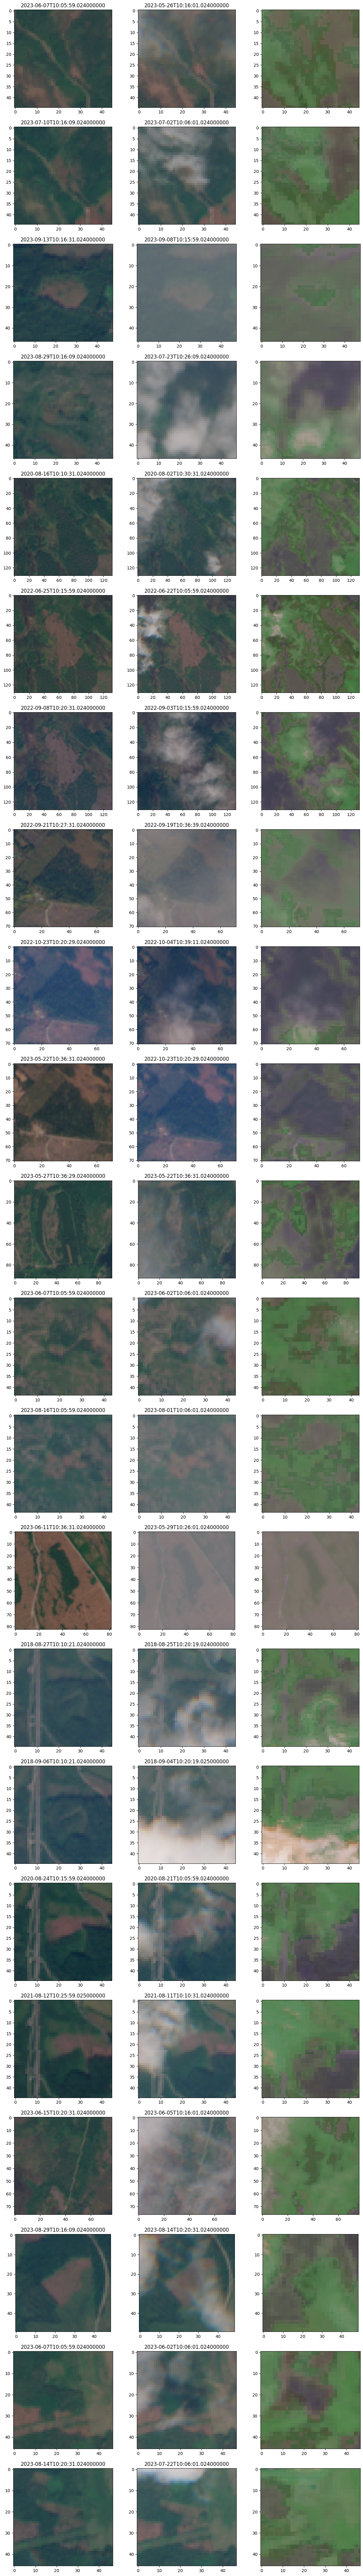

In [60]:
#Print clear, cloudy and predictions
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(preds_all[i]))
    pair_c+=1

In [61]:
#Evaluate through NMSE

n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm(np.square((im_clear[:,:,0:12])-(im_cloud[:,:,0:12])),axis=(0,1))**2
    norm_pred=np.linalg.norm(np.square((im_clear[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
    norm_gt=np.linalg.norm(np.square(im_clear[:,:,0:12]),axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))


NMSE before correction, Band 2: 2.305161168976403
NMSE after correction, Band 2: 0.202941701315814
 
NMSE before correction, Band 3: 6.4023670272455515
NMSE after correction, Band 3: 1.134380557656758
 
NMSE before correction, Band 4: 34.756426329439165
NMSE after correction, Band 4: 11.92896091492115
 
NMSE before correction, Band 5: 9.274040971995303
NMSE after correction, Band 5: 3.8292504967991903
 
NMSE before correction, Band 6: 0.49266081014717505
NMSE after correction, Band 6: 0.23610024492443202
 
NMSE before correction, Band 7: 0.26749905046269823
NMSE after correction, Band 7: 0.13769893142222053
 
NMSE before correction, Band 8: 0.21176322362223646
NMSE after correction, Band 8: 0.14501226386774294
 
NMSE before correction, Band 8A: 0.19049108048186822
NMSE after correction, Band 8A: 0.1031535906200902
 
NMSE before correction, Band 9: 4.577976280854691
NMSE after correction, Band 9: 2.796696124644676
 
NMSE before correction, Band 10: 33.61172229187585
NMSE after correctio

In [62]:
#Load wCOT_dum model
main_filepath='pytorch_models/COT_est_inp_wCOT_dum'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
 

In [63]:
#Make predictions and save with uncertanties

preds_all=[]
uncertainties_all=[]
for i,pair in enumerate(ims_all_wCOT_dum):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r)
        else:   
            pred=pred+model.predict(im_cloud_r)
    pred=pred/len(models)

    ##Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,est],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)

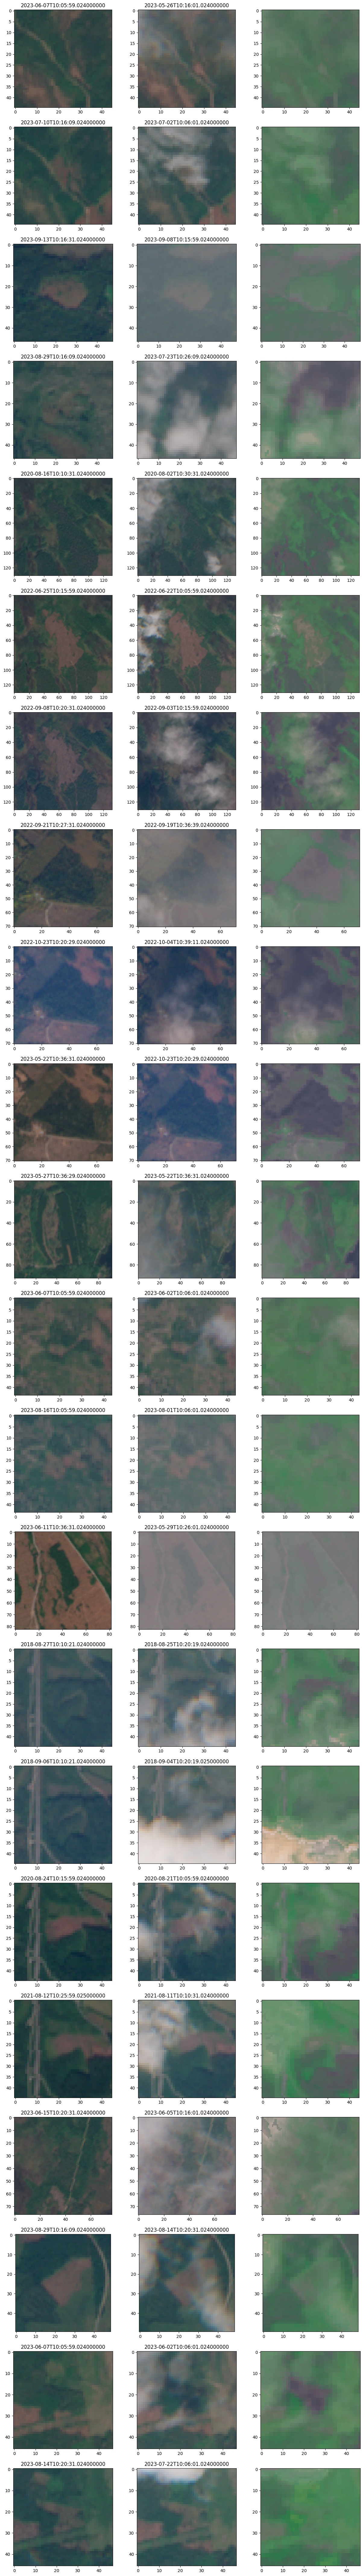

In [64]:
#Print clear, cloudy and predictions
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(preds_all[i]))
    pair_c+=1

In [65]:
#Evaluate through NMSE

n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm(np.square((im_clear[:,:,0:12])-(im_cloud[:,:,0:12])),axis=(0,1))**2
    norm_pred=np.linalg.norm(np.square((im_clear[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
    norm_gt=np.linalg.norm(np.square(im_clear[:,:,0:12]),axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))


NMSE before correction, Band 2: 2.305161168976403
NMSE after correction, Band 2: 0.07121979945199632
 
NMSE before correction, Band 3: 6.4023670272455515
NMSE after correction, Band 3: 0.6387887217007414
 
NMSE before correction, Band 4: 34.756426329439165
NMSE after correction, Band 4: 7.312451662145827
 
NMSE before correction, Band 5: 9.274040971995303
NMSE after correction, Band 5: 2.6920118473184425
 
NMSE before correction, Band 6: 0.49266081014717505
NMSE after correction, Band 6: 0.18620387818548087
 
NMSE before correction, Band 7: 0.26749905046269823
NMSE after correction, Band 7: 0.11664523719784294
 
NMSE before correction, Band 8: 0.21176322362223646
NMSE after correction, Band 8: 0.12845264377382892
 
NMSE before correction, Band 8A: 0.19049108048186822
NMSE after correction, Band 8A: 0.10639568549664508
 
NMSE before correction, Band 9: 4.577976280854691
NMSE after correction, Band 9: 1.609999188111216
 
NMSE before correction, Band 10: 33.61172229187585
NMSE after corre